# Testing Speed and Accuracy of RAG (WIP)

This notebook shows the following: 
* RAG LangChain pipeline with three different repositories
*  speed tests
   *  embedding time of different models with different VBs
---

## Imports

In [88]:
from tqdm.notebook import tqdm
from langchain.vectorstores import Chroma
import faiss
from langchain_community.vectorstores import FAISS
from langchain.document_loaders import DirectoryLoader, UnstructuredMarkdownLoader, PythonLoader, NotebookLoader
from langchain.text_splitter import MarkdownTextSplitter, RecursiveCharacterTextSplitter, PythonCodeTextSplitter
from langchain.embeddings import OllamaEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.llms import Ollama
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import numpy as np
import time
import matplotlib.pyplot as plt

---

## Data Ingestion
Using specific data loaders

In [2]:
paths = ["./sage-website/docs/", "./sage-website/news/", "./sage-data-client/", "./pywaggle/"]

In [3]:
# Recursively loads all "file_type" files in a list of directory "paths" with the appropriate "loader_class"
## returns a combined list of Documents from all paths
def repo_class_loader(paths, glob, loader_cls):
    combined_docs = []
    for path in paths:
        dir_loader = DirectoryLoader(path, glob=glob, loader_cls=loader_cls, recursive=True)
        docs = dir_loader.load()
        combined_docs.extend(docs)

    return combined_docs

In [4]:
%%time

# Load all Markdown files
md_docs = repo_class_loader(paths, './*.md', UnstructuredMarkdownLoader)
md_docs


CPU times: user 3.01 s, sys: 461 ms, total: 3.47 s
Wall time: 16.9 s


[Document(metadata={'source': 'sage-website/docs/contact-us.md'}, page_content='sidebar_label: Contact us\n\nContact us\n\nEmail\n\nFor support, general questions, or comments, you can always reach us at:\n\nsupport@waggle-edge.ai\n\nMessage Board\n\nWe also encourage developers and users to start a new topic or issue on the Waggle sensor message board:\n\nGitHub Discussions'),
 Document(metadata={'source': 'sage-website/docs/reference-guides/sesctl.md'}, page_content="sidebar_label: sesctl sidebar_position: 2\n\nsesctl: a tool to schedule jobs in Waggle edge computing\n\nThe tool sesctl is a command-line tool that communicates with an Edge scheduler in the cloud to manage user jobs. Users can create, edit, submit, suspend, and remove jobs via the tool.\n\nInstallation\n\nThe tool can be downloaded from the edge scheduler repository and be run on person's desktop or laptop.\n\n:::note Please make sure to download the correct version of the tool based on the system architecture. For exa

In [5]:
%%time

# Load all python files
py_docs = repo_class_loader(paths, './*.py', PythonLoader)
py_docs


CPU times: user 11.1 ms, sys: 14.3 ms, total: 25.4 ms
Wall time: 39.6 ms


[Document(metadata={'source': 'sage-data-client/tests/test_query.py'}, page_content='import unittest\nimport sage_data_client\nfrom io import BytesIO\nfrom datetime import datetime, timedelta\nimport pandas as pd\n\n\nclass TestQuery(unittest.TestCase):\n    def assertValueResponse(self, df):\n        self.assertIn("name", df.columns)\n        df.name.str\n        self.assertIn("timestamp", df.columns)\n        df.timestamp.dt\n        self.assertIn("value", df.columns)\n\n    def test_empty_response(self):\n        self.assertValueResponse(\n            sage_data_client.query(\n                start="-2000d",\n                filter={\n                    "name": "should.not.every.exist.XYZ",\n                },\n            )\n        )\n\n    def test_check_one_of_head_or_tail(self):\n        with self.assertRaises(ValueError):\n            sage_data_client.query(\n                start="2021-01-01T10:30:00",\n                end="2021-01-01T10:31:00",\n                head=3,\n    

In [6]:
%%time

# Load all notebook files
ipynb_docs = repo_class_loader(paths, './*.ipynb', NotebookLoader)
ipynb_docs


CPU times: user 83.6 ms, sys: 57 ms, total: 141 ms
Wall time: 168 ms


[Document(metadata={'source': 'sage-data-client/examples/plotting_example.ipynb'}, page_content='\'markdown\' cell: \'[\'# Basic Plotting Example\']\'\n\n\'code\' cell: \'[\'import sage_data_client\']\'\n\n\'markdown\' cell: \'["First, we\'ll query the last 7 days of temperature data from W022\'s BME680 sensor."]\'\n\n\'code\' cell: \'[\'df = sage_data_client.query(\\n\', \'    start="-7d",\\n\', \'    filter={\\n\', \'        "name": "env.temperature",\\n\', \'        "vsn": "W022",\\n\', \'        "sensor": "bme680",\\n\', \'    }\\n\', \')\']\'\n\n\'markdown\' cell: \'["Next, we\'ll plot a simple line chart."]\'\n\n\'code\' cell: \'[\'df.set_index("timestamp").value.plot()\']\'\n\n\'markdown\' cell: \'["Finally, we\'ll plot the temperature distribution."]\'\n\n\'code\' cell: \'[\'df.value.hist(bins=100)\']\'\n\n\'code\' cell: \'[]\'\n\n'),
 Document(metadata={'source': 'sage-data-client/examples/contrib/geospatial-mapping-example.ipynb'}, page_content='\'markdown\' cell: \'[\'# Geos

---

## Helper Functions and Globals

In [95]:
# Splits and combines all md, py, ipynb docs based on chunk size and chunk overlap
# Returns combined splits and size
def split_and_combine_docs(chunk_size, chunk_overlap):
     # Split Markdown files
    md_splitter = MarkdownTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    md_splits = md_splitter.split_documents(md_docs)

    # Split Python files
    py_splitter = PythonCodeTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    py_splits = py_splitter.split_documents(py_docs)

    # Split Notebook files
    ipynb_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    ipynb_splits = ipynb_splitter.split_documents(ipynb_docs)

    # combine splits
    combined_splits = md_splits + py_splits + ipynb_splits

    return combined_splits, len(combined_splits)

In [71]:
# This function is used to combine the list of contexts retrieved during RAG
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [72]:
# List of questions
text_questions = [
    "Why is the sky blue?",
    "What is the Sage project?",
    "Is there a concrete example of a Sage node being used?",
    "Can you give me a breakdown of the Sage and Waggle architecture/infrastructure?"
]

code_questions = [
    "Can you provide the code to make a blue box in Python?",
    "Can you provide a simple Waggle plugin that captures an image and publishes the average RGB values?",
    "Can you provide the code to plot the temperature of node W0B0 for the last three hours?"
]

In [73]:
# Sage template and prompt
sage_template = """You are an expert on the Sage project, and you can answer any question related to it.
Use ONLY the context about the Sage project to answer in as much detail possible the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
If asked to provide code, only generate code provided in the context.

{context}

Question: {question}"""

sage_prompt = ChatPromptTemplate.from_template(sage_template)

In [74]:
# The base model for generation
llm = Ollama(model='llama3.1')

In [78]:
# Embedding models
mxbai_embed_large = OllamaEmbeddings(model='mxbai-embed-large')


model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
mpnet_base_v2 = HuggingFaceEmbeddings(
                model_name="sentence-transformers/all-mpnet-base-v2",
                model_kwargs=model_kwargs,
                encode_kwargs=encode_kwargs
)


/Users/aldomalaquias/miniconda3/envs/sage/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/Users/aldomalaquias/miniconda3/envs/sage/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/aldomalaquias/miniconda3/envs/sage/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by

---

## Test Speeds

In [96]:
# Test speed of embedding given 3 different split amounts at a fixed chunk size, chunk overlap, and vectorbase
def plot_embed_speeds(models):
    chunk_size = 300
    chunk_overlap = 0
    number_points = 3
    splits, size = split_and_combine_docs(chunk_size, chunk_overlap)
    splits_string = [doc.page_content for doc in splits]
    indices = np.linspace(0, size, number_points, dtype=int)
    times1 = []
    times2 = []

    for amount in indices:
        st = time.time()
        vb = Chroma.from_documents(splits[0:amount+1], models[0])
        et = time.time()
        diff = et - st
        times1.append(diff)

        st = time.time()
        vb2 = FAISS.from_texts(splits_string[0:amount+1], models[1])
        et = time.time()
        diff = et - st
        times2.append(diff)
    
    plt.scatter(indices, times1, c='b', marker='o')
    plt.scatter(indices, times2, c='g', marker='x')
    classes = ['mxbai-embed-large', 'mpnet-base-v2']
    plt.legend(labels=classes)
    plt.xlabel("Number of splits")
    plt.ylabel("Time (s)")
    plt.show()

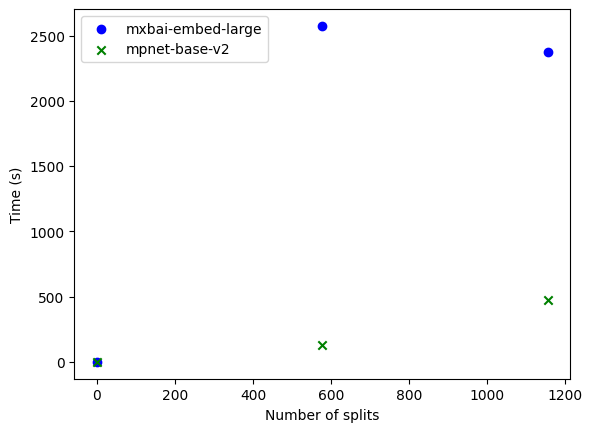

In [97]:
plot_embed_speeds([mxbai_embed_large, mpnet_base_v2])